In [1]:
import math
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
def generate_sample_f_star(N, t="uniform", densities=None, selected_densities=None, s=5, cvx_rand=False, dist_rect=None, N_pdf=1000):
    # Generate a sample of n points in [0,1]
    # t can be uniform, convex, rect, in the case of convex, a convex combination of elements of gaussian 
    # densities will be taken with a sparsity s
    #we return also return the distribution on [0,1], 1000 points
    if t=="uniform":
        X_ = np.random.uniform(low=0, high=1, size=N)
        return X_, 1./N_pdf*np.ones(N_pdf)
    if t=="convex":
        if densities == None:
            raise ValueError("Densities were not given")
        def generate_points(N, s, densities, selected_densities, sample_repartition_among_clusters, weights):
            print "selected densities: ", sorted(zip(selected_densities,weights))
            X = np.array([])
            t=0
            #We generate the sample according to the selected densities and the weights
            for i in range(s):
                X=np.hstack((X, densities[selected_densities[i]].rvs(sample_repartition_among_clusters[i])))
            np.random.shuffle(X)
            return X, np.apply_along_axis(lambda x: weights.dot(np.array([densities[i].pdf(x) for i in selected_densities])), 0, np.linspace(0,1,N_pdf)), weights, selected_densities
        # We select randomly s elements in densities, then we have two possibilities depending on cvx_rand:
        # false: equal weight for each densities, w=1/s
        # true: random weights
        if selected_densities == None:
            selected_densities = np.random.choice(len(densities), s, replace=False)
        s = len(selected_densities)
        if cvx_rand:
            #We generate the weights
            weights = np.random.randint(N*100, size=(1, s))[0]
            weights = 1.*weights/weights.sum()
            sample_repartition_among_clusters = np.random.multinomial(N, weights, size=1)[0]
            return generate_points(N, s, densities, selected_densities, sample_repartition_among_clusters, weights)
        else:
            a = round(N/s)*np.ones(s)
            #We adjust the size to the last element
            a[-1]= a[-1]-(a.sum()-N)
            sample_repartition_among_clusters = a.astype(int)
            return generate_points(N, s, densities, selected_densities, sample_repartition_among_clusters, a/a.sum())
    if t=="rect":
        def prob_estim(x, dist_rect):
            for intval in sorted(dist_rect.keys()):
                if x <= intval[1]:
                    return dist_rect[intval]
        X_ = np.linspace(0,1,10*N)
        proba = np.array([prob_estim(x, dist_rect) for x in X_])
        proba = proba/proba.sum()
        return np.random.choice(X_, size=N, p=proba), np.array([prob_estim(x,dist_rect) for x in np.linspace(0, 1, N_pdf)])
                
            

        
        
        
        

selected densities:  [(2, 0.12767269147319424), (12, 0.0456543972166732), (22, 0.31498332106706939), (29, 0.45284497672595891), (39, 0.058844613517104273)]


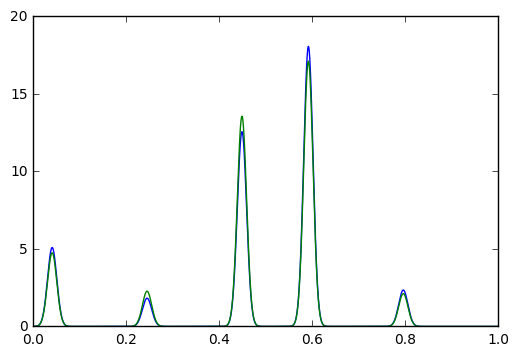

In [5]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from algorithm import WeightEstimator

nodes = np.linspace(0, 1, 50)
var = 10**(-4)
densities = [multivariate_normal(m, var) for m in nodes]
dist_rect = {
    (0,1./5) : 10./7,
    (1./5,2./5) : 5./7,
    (2./5,3./5) : 10./7,
    (3./5,4./5) : 0,
    (4./5,1) : 10./7
}
n_pdf = 100000
#X, f_star = generate_sample_f_star(10000, t="rect", densities=densities, cvx_rand=False, s=5, dist_rect=dist_rect, N_pdf=n_pdf)
#X, f_star = generate_sample_f_star(1000, t="uniform", densities=densities, cvx_rand=False, s=5, dist_rect=dist_rect,  N_pdf=n_pdf)#
X, f_star,  weights_star, selected_densities_star = generate_sample_f_star(1000, t="convex", densities=densities, cvx_rand=True, s=5, dist_rect=dist_rect,  N_pdf=n_pdf)
#X, f_star, weights_star, selected_densities_star = generate_sample_f_star(100, t="convex", densities=densities, cvx_rand=False, s=5, dist_rect=dist_rect,  N_pdf=n_pdf)
#plt.hist(X, bins=1000)  # plt.hist passes it's arguments to np.histogram

#estimation
cl = WeightEstimator(densities_dict=densities, select_threshold=10e-3)
cl.fit(X)
estim_weighted_densities=cl.select_densities()
selected_densities_estim, weights_estim = np.array(zip(*estim_weighted_densities))
f_estim = np.apply_along_axis(lambda x: weights_estim.dot(np.array([densities[i].pdf(x) for i in selected_densities_estim.astype(int)])), 0, np.linspace(0,1,n_pdf))

plt.plot(np.linspace(0,1,n_pdf),f_star)
plt.plot(np.linspace(0,1,n_pdf),f_estim)
plt.show()


# Evaluation

In [6]:
#Kullback Leibler:

from scipy.stats import entropy
#import scipy.integrate as integrate
#integrate.quad(lambda x: x**2, 0, 1)

print "KL-div:", entropy(f_star, f_estim)
print "L2 norm", 1./n_pdf*np.linalg.norm(f_star-f_estim,axis=0)**2
print weights_estim, weights_star

KL-div: 0.00544466308297
L2 norm 0.0380521915451
[ 0.08  0.07  0.34  0.36  0.15] [ 0.32239702  0.05492519  0.06815647  0.36851417  0.18600715]


# SPADES Implementation

In [7]:
#from SPADES AND MIXTURE MODELS
#By Florentina Bunea, Alexandre B. Tsybakov,
#Marten H. Wegkamp and Adrian Barbu
#another implementation

from cvxpy import *

In [8]:
def F(x):
    return np.array([d.pdf(x) for d in densities]).T

In [9]:
#objective = Minimize(-2./X.shape[0]*sum_entries(F_X*lambda_) + norm2_f_sq + 2*norm1(w*lambda_) )
#prob = Problem(objective)
#prob.solve()

## selection des poids pour spades

In [10]:
#n=10000
#(1./n*np.array([x**2 for x in np.linspace(0,1,n)])).sum()
F_X=F(X)

In [11]:
import scipy.integrate as integrate
from numba import jit
K = len(densities)

@jit()
def couple_dens(x,i,j):
    return densities[i].pdf(x)*densities[j].pdf(x)

#this code generate a matrix where the comp.(i,j) is int(densities[i]*densities[j])
def F_int_prod_matrix():
    F_int_prod_matrix = np.zeros([K,K])
    for i in range(K):
        for j in range(i,K):
            F_int_prod_matrix[i,j]=integrate.quad(couple_dens,-np.inf,np.inf,args=(i,j))[0]
    return F_int_prod_matrix + np.triu(F_int_prod_matrix,1).T

#differential of -2/n * sum_{i=1}^K(f_lambd(X_i))+ ||f_lambd||^2
# which is -2/n * sum_{i=1}^K f_l(X_i) + 2*sum_{i=1}^K lambd_j*int(f_j(x)*f_l(x))
#@jit()
def f_diff(l, lambd, F_X, f_int_prod_matrix):
    #import pdb; pdb.set_trace()
    return -2./F_X.shape[0]*F_X[:,l].sum() + 2*f_int_prod_matrix[:,l].dot(lambd)

#Evaluation of the norm2 of f_lambd
def norm_2_integrand(x,lambd_):
    return (np.array([d.pdf(x) for d in densities]).dot(lambd_))**2

def f_norm2(lambd_):
    return integrate.quad(norm_2_integrand,-np.inf,np.inf,args=lambd_)[0]

#for line search
#@jit()
def f(lambd_, w, F_X):
    return -2./F_X.shape[0]*F_X.dot(lambd_).sum()+f_norm2(lambd_) + w*np.linalg.norm(lambd_,1)

#grad for line search
def f_grad(lambd_, w):
    return np.array([f_diff(l,lambd_) for l in range(K)]) + w*np.sign(lambd_)



In [12]:
f_int_prod_matrix = F_int_prod_matrix()

In [13]:
def min_direct(lambd, l, F_X, w):
    lambda_ = Variable(K)
    #pour le calcul de l'integrale
    X_int = np.linspace(0,1,10000)
    F_int = F(X_int)*lambda_
    norm2_f_sq = sum_entries(F_int**2)
    #prepare constraints
    lst_cst = range(K,l)
    constraints = [lambda_[i]==lambd[i] for i in lst_cst]
    #problem
    objective = Minimize(-2./F_X.shape[0]*sum_entries(F_X*lambda_) + norm2_f_sq + 2*norm1(w*lambda_) )
    prob = Problem(objective,constraints)
    prob.solve()
    return np.array(lambda_.value).reshape(1,K)[0]

In [14]:
from scipy.optimize import minimize
#@jit()
def f_one_direct(y, l, lambd_, w, F_X, f_int_prod_matrix):
    lambd_[l]=y
    return f(lambd_, w, F_X)

def f_grad_one_direct(y, l, lambd_, w, F_X, F_int_prod_matrix):
    #import pdb; pdb.set_trace()
    return -2./F_X.shape[0]*F_X[:,l].sum() + 2*f_int_prod_matrix[:,l].dot(lambd_) + w*np.sign(y)


#@jit()
def min_direct_2(lambd, l, w, F_X, f_int_prod_matrix):
    res = minimize(f_one_direct, 
                   lambd[l], 
                   args=(l, lambd, w, F_X, f_int_prod_matrix), 
                   method="BFGS",
                   jac=f_grad_one_direct, 
                   options={"maxiter":1,
                            "disp": True
                           
                           }
                  )["x"][0]
    lambd_res = np.copy(lambd)
    lambd_res[l]=res
    return lambd_res
        
    

In [162]:
#@jit()
def spades(w, F_X, f_int_prod_matrix):
    eps_tresh = 1e-5
    lambd = 1./K*np.ones(K)
    lambd_old = np.zeros(K)
    #import pdb; pdb.set_trace()
    it = 0
    while np.linalg.norm(lambd-lambd_old,1) > eps_tresh:
        #print "iteration: ", it, "norm: ", np.linalg.norm(lambd-lambd_old,1)
        for j in range(K):
            lambd_old = np.copy(lambd)
            lambd_j_0 = np.copy(lambd)
            lambd_j_0[j]=0
            if np.abs(f_diff(j, lambd_j_0, F_X, f_int_prod_matrix)) < w:
                lambd = lambd_j_0
            else:
                #lambd = min_direct_2(lambd, j, w, F_X, F_int_prod_matrix)
                lambd = min_direct(lambd, j, F_X, w)
        it+=1
    return lambd

In [156]:
lambd = spades(0.1, F_X, f_int_prod_matrix)
lambd[0]

iteration:  0 norm:  1.0
[  2.13897095e-12   4.58383968e-12  -5.18772794e-11   2.60160027e-10
  -5.24786297e-10  -3.57837194e-09   8.23722973e-09   3.67388163e-06
  -7.23131019e-08  -2.21121909e-08   4.27210178e-09  -1.66118273e-10
  -1.46081763e-10   4.63177732e-11   4.34154741e-11  -1.12069134e-10
  -2.86289010e-10   3.87907520e-09  -1.51532463e-08  -5.14009429e-08
   1.13947313e-06   4.39159013e-05   4.53084115e-06  -2.34165937e-08
   3.45736548e-07   9.13613936e-06  -6.45428393e-08  -1.78535127e-08
   3.70470541e-09  -2.44142970e-10  -9.65224624e-11   4.88809145e-11
  -1.43257378e-11   3.24332278e-12  -5.69467593e-13   5.07909470e-14
   2.19664873e-14   5.67209066e-14  -7.00292500e-13   4.08600683e-12
  -1.80090440e-11   6.02860365e-11  -1.13997011e-10  -2.88763912e-10
   3.89925095e-09  -1.53667063e-08  -5.30107661e-08   1.36304775e-06
   3.35921702e-05   4.09606622e-06]
[  2.13897095e-12   0.00000000e+00  -5.18772794e-11   2.60160027e-10
  -5.24786297e-10  -3.57837194e-09   8.237

2.1389709525726919e-12

In [137]:
lambd.reshape(1,K)[0]

array([ -7.42177716e-15,   1.21005498e-13,   1.22271415e-12,
        -2.22223528e-11,  -2.37625973e-10,  -1.96460198e-10,
         2.82405831e-09,   3.66738723e-05,  -3.81108594e-07,
        -1.06168805e-08,  -1.23601098e-09,   2.82730368e-11,
         6.84061167e-12,  -1.67039356e-13,  -2.16227370e-13,
         4.21079968e-12,   3.55471633e-11,  -9.04410010e-10,
        -9.64101284e-09,  -2.22250294e-08,   1.11927545e-05,
         4.39659022e-04,   4.52351111e-05,  -7.50091458e-09,
         3.44653781e-06,   9.12277358e-05,  -4.03869909e-08,
        -1.33837385e-08,  -1.23392677e-09,   1.95374407e-11,
         5.52120918e-12,  -3.58714121e-14,  -5.15776227e-14,
         6.56854547e-15,  -2.50620326e-15,   2.08202054e-14,
         6.37168691e-15,  -1.78764203e-12,  -1.02136506e-11,
         3.96203083e-10,   3.42024754e-09,   7.21287473e-09,
        -6.00362833e-06,   3.17280424e-05,  -1.08012467e-04,
         3.25324075e-04,  -9.41361113e-04,   2.68686984e-03,
        -7.18647484e-03,

In [ ]:
weight_spades_2 = np.array([lambd[i] if type(lambd[i]) == int else np.array(lambd[i])[0][0] for i in range(K)])

In [ ]:
f_estim_spades_2 = np.apply_along_axis(lambda x: weight_spades_2.dot(np.array([d.pdf(x) for d in densities])), 0, np.linspace(0,1,n_pdf))

#plt.plot(np.linspace(0,1,n_pdf),f_star)
plt.plot(np.linspace(0,1,n_pdf),f_estim_spades_2)
plt.show()

In [ ]:
def spades_full(w, F_X):
    lambda_ = Variable(K)
    X_int = np.linspace(0,1,10000)
    F_int = F(X_int).T*lambda_
    norm2_f_sq = sum_entries(F_int**2)
    objective = Minimize(-2/X.shape[0]*sum_entries(F_X*lambda_) + norm2_f_sq + 2*norm1(w*lambda_) )
    prob = Problem(objective)
    prob.solve()
    return np.array(lambda_.value)


In [ ]:
for i in range(10):
    w=10**(2-i)
    weights_spades = np.array(spades_full(w)).reshape(K)
    f_estim_spades = np.apply_along_axis(lambda x: weights_spades.dot(np.array([d.pdf(x) for d in densities])), 0, np.linspace(0,1,n_pdf))
    
    plt.plot(np.linspace(0,1,n_pdf),f_star)
    plt.plot(np.linspace(0,1,n_pdf),f_estim_spades)
    plt.show()

In [ ]:
1e-3

In [ ]:
weights_spades.dot(np.array([d.pdf(0) for d in densities]))

In [102]:
def non_zero_elemts(w, F_X, f_int_prod_matrix):
    lambd = spades(w, F_X, f_int_prod_matrix)
    return len(lambd[lambd>1e-10]), lambd

In [103]:
#GBM Methods
from queue import Queue
alpha = 1e-2
def gbm(X, F_X, f_int_prod_matrix, alpha=1e-2):
    w_vect = -np.ones(K)
    w_vect[0] = 100
    w_vect[-1] = 0
    #import pdb; pdb.set_trace()
    q = Queue()
    q.put((w_vect[0],w_vect[-1]))
    while not q.empty():
        a,b = q.get()
        w = 1.0*(a+b)/2
        k = non_zero_elemts(w, F_X, f_int_prod_matrix)[0]-1
        if w_vect[k]==(-1):
            w_vect[k]=w
        t = non_zero_elemts(a, F_X, f_int_prod_matrix)[0]
        if np.abs(t-k) > 1 and np.abs(a-w) > alpha:
            print "put a,w",a,w
            q.put((a,w))
        t = non_zero_elemts(b, F_X, f_int_prod_matrix)[0]
        if np.abs(t-k) > 1 and np.abs(b-w) > alpha:
            print "put b, w ", b, w
            q.put((w,b))
    return w_vect

In [104]:
non_zero_elemts(1, F_X, f_int_prod_matrix)

KeyboardInterrupt: 

In [159]:
gbm(X, F_X,f_int_prod_matrix)

iteration:  0 norm:  1.0
iteration:  1 norm:  0.02
iteration:  0 norm:  1.0
iteration:  1 norm:  0.02
iteration:  0 norm:  1.0


SolverError: Solver 'ECOS' failed. Try another solver.

In [160]:
def D_comp(X, j, p):
    mask = np.ones(X.shape, dtype=bool)
    mask[X.shape[0]/p*j:X.shape[0]/p*(j+1)] = False
    return X[mask]

def weight_select_proc(X):
    f_int_prod_matrix = F_int_prod_matrix()
    p=10
    #Dj
    part_X = [X[X.shape[0]/p*i:X.shape[0]/p*(i+1)] for i in range(p)]
    #we create D-j : D\Dj
    part_X_comp = [D_comp(X,l,p) for l in range(K)]
    L = np.zeros([K,p])
    #import pdb; pdb.set_trace()

    for k in range(K):
        for j in range(p):
            F_X_j = F(part_X_comp[j])
            w_k_j = gbm(part_X_comp[j], F_X_j, f_int_prod_matrix)
            print w_k_j

In [165]:
a = weight_select_proc(X)

put b, w  0.0 50.0
put b, w  0.0 25.0
put b, w  0.0 12.5
put b, w  0.0 6.25
put b, w  0.0 3.125
put b, w  0.0 1.5625
put b, w  0.0 0.78125
put a,w 0.78125 0.390625
put b, w  0.0 0.390625
put b, w  0.390625 0.5859375
put b, w  0.0 0.1953125
put a,w 0.5859375 0.48828125
put b, w  0.390625 0.48828125
put b, w  0.0 0.09765625
put a,w 0.5859375 0.537109375
put b, w  0.48828125 0.537109375
put a,w 0.48828125 0.439453125
put a,w 0.09765625 0.048828125
put b, w  0.0 0.048828125
put b, w  0.537109375 0.5615234375
put b, w  0.48828125 0.5126953125
put b, w  0.439453125 0.4638671875
put a,w 0.09765625 0.0732421875
put b, w  0.048828125 0.0732421875
put b, w  0.0 0.0244140625
put a,w 0.09765625 0.08544921875
put b, w  0.0732421875 0.08544921875
put a,w 0.0732421875 0.06103515625
put b, w  0.048828125 0.06103515625
put a,w 0.0244140625 0.01220703125
[  1.00000000e+02   6.25000000e+00  -1.00000000e+00   1.56250000e+00
  -1.00000000e+00   7.81250000e-01  -1.00000000e+00   5.85937500e-01
  -1.00000000

KeyboardInterrupt: 

In [46]:
mask = np.ones(X.shape, dtype=bool)
mask[X.shape[0]/10*3:X.shape[0]/10*(3+1)] = False
X[mask]

SyntaxError: invalid syntax (<ipython-input-46-ef8ce26d37fb>, line 1)

In [50]:
np.array([[1,2],[4,5]])[0,0]

1

In [57]:
F_X.shape

(1000, 50)

In [153]:
pwet = range(K)
l =5
range(K,5)

[]

In [7]:
densities

In [53]:
from spades import SpadesEstimator
se =SpadesEstimator(densities)

In [54]:
b = se.gbm(F_X)

a,b =  100.0 0.0
put w, b  50.0 0.0
a,b =  50.0 0.0
put w, b  25.0 0.0
a,b =  25.0 0.0
put w, b  12.5 0.0
a,b =  12.5 0.0
put a,w 12.5 6.25
put w, b  6.25 0.0
a,b =  12.5 6.25
put w, b  9.375 6.25
a,b =  6.25 0.0
put w, b  3.125 0.0
a,b =  9.375 6.25
put w, b  7.8125 6.25
a,b =  3.125 0.0
put w, b  1.5625 0.0
a,b =  7.8125 6.25
put a,w 7.8125 7.03125
a,b =  1.5625 0.0
put w, b  0.78125 0.0
a,b =  7.8125 7.03125
put a,w 7.8125 7.421875
a,b =  0.78125 0.0
put a,w 0.78125 0.390625
put w, b  0.390625 0.0
a,b =  7.8125 7.421875
put w, b  7.6171875 7.421875
a,b =  0.78125 0.390625
a,b =  0.390625 0.0
put a,w 0.390625 0.1953125
put w, b  0.1953125 0.0
a,b =  7.6171875 7.421875
a,b =  0.390625 0.1953125
put w, b  0.29296875 0.1953125
a,b =  0.1953125 0.0
put w, b  0.09765625 0.0
a,b =  0.29296875 0.1953125
a,b =  0.09765625 0.0
put a,w 0.09765625 0.048828125
put w, b  0.048828125 0.0
a,b =  0.09765625 0.048828125
put w, b  0.0732421875 0.048828125
a,b =  0.048828125 0.0
put w, b  0.0244140625 

In [57]:
res = se.spades_solver(b,F_X)

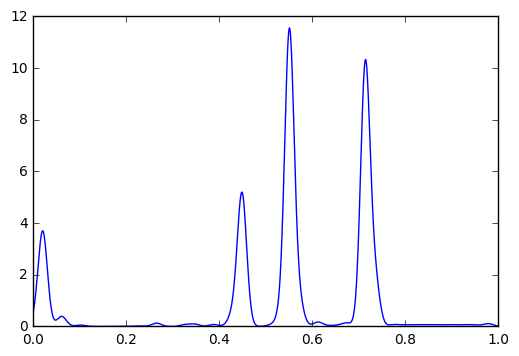

In [58]:
res = res.reshape(50)
f_estim_spades_2 = np.apply_along_axis(lambda x: res.dot(np.array([d.pdf(x) for d in densities])), 0, np.linspace(0,1,n_pdf))


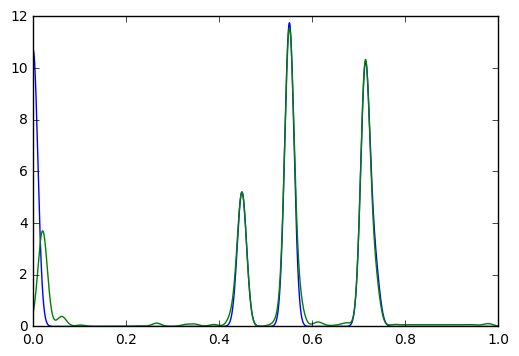

In [59]:
#plt.plot(np.linspace(0,1,n_pdf),f_star)
res = res.reshape(50)
f_estim_spades_2 = np.apply_along_axis(lambda x: res.dot(np.array([d.pdf(x) for d in densities])), 0, np.linspace(0,1,n_pdf))

plt.plot(np.linspace(0,1,n_pdf),f_star)
plt.plot(np.linspace(0,1,n_pdf),f_estim_spades_2)
plt.show()

In [34]:
se.N = X.shape[0]
se.w_select_cv(X)

(900, 50)
a,b =  100.0 0.0
put w, b  50.0 0.0
a,b =  50.0 0.0
put w, b  25.0 0.0
a,b =  25.0 0.0
put a,w 25.0 12.5
put w, b  12.5 0.0
a,b =  25.0 12.5
a,b =  12.5 0.0
put a,w 12.5 6.25
put w, b  6.25 0.0
a,b =  12.5 6.25
put w, b  9.375 6.25
a,b =  6.25 0.0
put w, b  3.125 0.0
a,b =  9.375 6.25
put a,w 9.375 7.8125
a,b =  3.125 0.0
put w, b  1.5625 0.0
a,b =  9.375 7.8125
put a,w 9.375 8.59375
a,b =  1.5625 0.0
put a,w 1.5625 0.78125
put w, b  0.78125 0.0
a,b =  9.375 8.59375
a,b =  1.5625 0.78125
put w, b  1.171875 0.78125
a,b =  0.78125 0.0
put a,w 0.78125 0.390625
put w, b  0.390625 0.0
a,b =  1.171875 0.78125
a,b =  0.78125 0.390625
put w, b  0.5859375 0.390625
a,b =  0.390625 0.0
put a,w 0.390625 0.1953125
put w, b  0.1953125 0.0
a,b =  0.5859375 0.390625
put a,w 0.5859375 0.48828125
a,b =  0.390625 0.1953125
put w, b  0.29296875 0.1953125
a,b =  0.1953125 0.0
put w, b  0.09765625 0.0
a,b =  0.5859375 0.48828125
put w, b  0.537109375 0.48828125
a,b =  0.29296875 0.1953125
put w, b

SolverError: Solver 'ECOS' failed. Try another solver.

In [32]:
X.shape

(1000,)

In [10]:
from spades import SpadesEstimator
se =SpadesEstimator(densities)

In [11]:
se.w_select_cv(X)

In [50]:
x_int = np.linspace(0,1,1000)
1./x_int.shape[0]*np.apply_along_axis(lambda x: x**2, 0, x_int).sum()

0.33350016683350014

In [63]:
e = np.array([1,2,0,3,4,2,5])

In [64]:
np.array([e[i] +0.5*i*np.log(X.shape[0])/X.shape[0] for i in range(len(e))])

array([ 1.        ,  2.00345388,  0.00690776,  3.01036163,  4.01381551,
        2.01726939,  5.02072327])

In [65]:
np.log(10)

2.3025850929940459

In [12]:
se.L_final

array([  0.        ,  -3.13287591,  -6.83846244, -11.92532779, -12.76248605])

In [13]:
se.k_final

4

In [17]:
adapt_dantzig.beta_hat_gen(X)

array([  2.23580168,   1.98809192,   9.05944834,  10.01390739,   3.70524816])

In [18]:
densities

In [19]:
for d in densities:
    print d.mean

[ 0.]
[ 0.25]
[ 0.5]
[ 0.75]
[ 1.]


In [20]:
d.mean

array([ 1.])

In [21]:
X

array([ 0.48442446,  0.25491306,  1.01092353,  0.00472832,  0.50223982,
        0.00183039,  0.50316482,  0.49037946,  0.7509135 ,  0.49990594,
        0.75242062,  0.7362281 ,  0.7582889 ,  0.25503542,  0.01238456,
        0.74740327,  0.51128863,  0.75211333,  0.75527835,  0.99884283,
        0.49207845,  0.48618657,  0.49884748,  0.74855012,  0.50787544,
        0.75617411,  0.75071133,  0.5074367 ,  0.76090702,  0.4888139 ,
        0.23130733,  0.9836731 ,  0.73145199,  0.49729719,  0.99995359,
        0.75986035,  0.75214345,  0.73954261,  0.50587733,  0.75346333,
        0.73933509,  0.7629689 ,  0.73234248,  1.0115914 ,  0.25286611,
        0.49495355,  0.75621118, -0.02121087,  0.00563251,  0.52030684,
        1.01104487,  0.73973606,  0.76309923,  0.7623868 ,  0.75273533,
        0.98103154,  0.74145151,  1.01584234,  0.50230952,  0.7555648 ,
        0.49915082,  0.24260613,  0.01424634,  0.99147673,  0.49662458,
        0.76401275,  0.4819385 ,  0.4895665 ,  0.75075984,  0.76

In [54]:
a = np.arange(1000).reshape([1000,1])


In [75]:
def test_1(a):
    n = a.shape[0]
    return 1./(a*(a-1))*np.triu((a.T-a)**2).sum()

In [67]:
%timeit test_1()

100 loops, best of 3: 9.91 ms per loop


In [95]:
@jit
def test(a):
    r = 0
    n = a.shape[0]
    for i in range(a.shape[0]):
        for j in range(i):
            r+= (a[i]-a[j])**2
    return 1./(n*(n-1))*r

In [65]:
%timeit test

10000000 loops, best of 3: 34.3 ns per loop


In [166]:

from adaptiveDantzig import AdaptiveDantzigEstimator
adapt_dantzig = AdaptiveDantzigEstimator(densities)

In [121]:
adapt_dantzig.fit(X)
adapt_dantzig.beta_hat_gen(1)

array([  0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         7.65392974e-135,   3.98942280e+001])

In [101]:
%timeit adapt_dantzig.sigma_gen()

10 loops, best of 3: 30.3 ms per loop


In [96]:
%timeit [test(F_X[:,m]) for m in range(K)]

The slowest run took 2762.69 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 39.6 µs per loop


In [87]:
F_X.shape

(100, 5)

In [113]:
adapt_dantzig.eta_gamma_gen()

array([ 1.95271114,  1.40466724,  2.57145267,  2.65564773,  1.77642686])

In [140]:
%timeit adapt_dantzig.gram_matrix_gen()

1 loop, best of 3: 19.2 s per loop


In [146]:
adapt_dantzig.fit(X)

In [148]:
%timeit adapt_dantzig.sigma_tilde_gen()

1 loop, best of 3: 36.3 s per loop


In [152]:
t = Variable(50)

In [151]:
G = adapt_dantzig.gram_matrix

In [158]:
abs(G*t[1]-6)

Expression(CONVEX, POSITIVE, (50, 50))

In [181]:
nodes = np.linspace(0, 1, 20)
var = 10**(-4)
densities = [multivariate_normal(m, var) for m in nodes]
dist_rect = {
    (0,1./5) : 10./7,
    (1./5,2./5) : 5./7,
    (2./5,3./5) : 10./7,
    (3./5,4./5) : 0,
    (4./5,1) : 10./7
}
n_pdf = 100000
#X, f_star = generate_sample_f_star(10000, t="rect", densities=densities, cvx_rand=False, s=5, dist_rect=dist_rect, N_pdf=n_pdf)
#X, f_star = generate_sample_f_star(1000, t="uniform", densities=densities, cvx_rand=False, s=5, dist_rect=dist_rect,  N_pdf=n_pdf)#
X, f_star,  weights_star, selected_densities_star = generate_sample_f_star(100, t="convex", densities=densities, cvx_rand=True, s=5, dist_rect=dist_rect,  N_pdf=n_pdf)
#X, f_star, weights_star, selected_densities_star = generate_sample_f_star(100, t="convex", densities=densities, cvx_rand=False, s=5, dist_rect=dist_rect,  N_pdf=n_pdf)
#plt.hist(X, bins=1000)  # plt.hist passes it's arguments to np.histogram

selected densities:  [(0, 0.066059679670366189), (5, 0.19957466604638799), (12, 0.094437429387917854), (15, 0.18488735296072306), (18, 0.45504087193460491)]


In [183]:
from adaptiveDantzig import AdaptiveDantzigEstimator
adapt_dantzig = AdaptiveDantzigEstimator(densities)
lambda_dantzig = adapt_dantzig.fit(X)

array([ -9.61920429e-15,  -1.93397912e-12,   1.71758154e-15,
         8.91806258e-17,  -8.28242227e-14,   1.06405687e-01,
         4.90001340e-13,  -2.36290151e-14,   2.16041425e-17,
        -1.89643650e-20,   9.91740847e-16,  -1.09375085e-12,
         1.97825666e-02,  -1.75688568e-05,  -1.34616306e-14,
         8.22560673e-02,  -8.03850965e-14,   1.47661582e-14,
         2.55642261e-01,  -5.97077574e-05])

In [191]:
cl = WeightEstimator(densities_dict=densities, select_threshold=10e-3)
cl.fit(X)
estim_weighted_densities=cl.select_densities()
selected_densities_estim, weights_estim = np.array(zip(*estim_weighted_densities))
f_estim = np.apply_along_axis(lambda x: weights_estim.dot(np.array([densities[i].pdf(x) for i in selected_densities_estim.astype(int)])), 0, np.linspace(0,1,n_pdf))


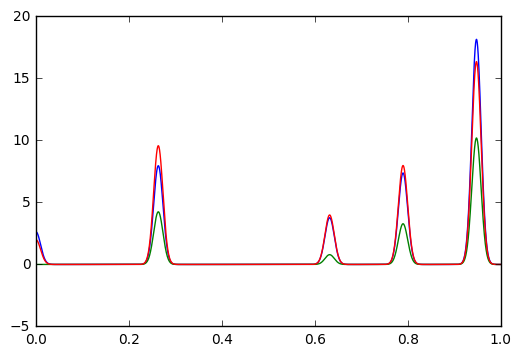

In [192]:
#plt.plot(np.linspace(0,1,n_pdf),f_star)
f_estim_dantzig = np.apply_along_axis(lambda x: lambda_dantzig.dot(np.array([d.pdf(x) for d in densities])), 0, np.linspace(0,1,n_pdf))

plt.plot(np.linspace(0,1,n_pdf),f_star)
plt.plot(np.linspace(0,1,n_pdf),f_estim_dantzig)
plt.plot(np.linspace(0,1,n_pdf),f_estim)
plt.show()

In [188]:
f_star.shape

(100000,)

# threading test

In [193]:
import Queue
import threading
import urllib2

# called by each thread
def get_url(q, url):
    q.put(urllib2.urlopen(url).read())

theurls = ["http://google.com", "http://yahoo.com"]

q = Queue.Queue()

for u in theurls:
    t = threading.Thread(target=get_url, args = (q,u))
    t.daemon = True
    t.start()

s = q.get()
print s

<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="fr"><head><meta content="text/html; charset=UTF-8" http-equiv="Content-Type"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>Google</title><script>(function(){window.google={kEI:'QQZ4WPjcE8ujsAGxmZewAQ',kEXPI:'750722,1351903,1352298,3700272,4029815,4032678,4038012,4043492,4045841,4048347,4053261,4062666,4063220,4065787,4067860,4068550,4069839,4069840,4072602,4072777,4073405,4073726,4073958,4074955,4075961,4075963,4076095,4076930,4076999,4078430,4078438,4079105,4079441,4079894,4080167,4080383,4081038,4081647,4082618,4083476,4084343,4084716,4084956,4085336,4086011,4086071,4086697,4087192,4087708,4089003,4089106,4089538,4090090,4090093,4090105,4090368,4090555,4090657,4090806,4090876,4090893,4091029,4091043,4091807,4092470,4092889,4092932,4093107,4093109,8300095,8300273,8300481,8300484,8504110,8507380,8507420,8507861,8508206,8508497,8509066,8509226,8509597,10200

In [209]:
ls

2017-01-13_00.01.33/  adaptiveDantzig.py   main.py
2017-01-13_00.01.46/  adaptiveDantzig.pyc  simu-Copy1.ipynb
2017-01-13_00.03.14/  algorithm.py	   simu.ipynb
2017-01-13_00.04.02/  algorithm.pyc	   simus.py
2017-01-13_00.10.11/  densities.py	   spades.py
2017-01-13_00.25.27/  densities.pyc	   spades.pyc
__pycache__/	      densities_tools.py


In [210]:
cd 2017-01-13_00.25.27/


/Users/mehdi/Dropbox/working folder/PHd/Text/weight_vector_estim_paper/weight_vector_estim_code/2017-01-13_00.25.27


In [211]:
ls


In [202]:
from os import listdir
from os.path import isfile, join
folder = "./"
onlyfiles = [f for f in listdir(folder) if (isfile(join(folder, f)) and f.startswith("res_K"))]

In [204]:
import pickle
for f in onlyfiles:
    print pickle.load(open(folder+f))

{'weight_vector_estim_lambda': [(0, 0.03000847281404928), (1, 0.08355772716276853), (2, 0.08552699490621746), (3, 0.09260099297849007), (4, 0.07930678430867902), (5, 0.1720296083200466), (6, 0.11945053640254823), (7, 0.17608382390634233), (8, 0.11071332960057036), (9, 0.05072163742410698)]}
{'weight_vector_estim_lambda': [(0, 0.021114143197693613), (1, 0.09023989548854389), (2, 0.08194253915093139), (3, 0.07069513944107678), (4, 0.14149146313567892), (5, 0.1440885536821948), (6, 0.14855862627957658), (7, 0.12106442726258576), (8, 0.11976528931446008), (9, 0.06103983260604815)]}
{'weight_vector_estim_lambda': [(0, 0.0795111037903125), (1, 0.15475190180579504), (2, 0.12231573493430106), (3, 0.07563821016432903), (4, 0.07272827217580424), (5, 0.09163978869400229), (6, 0.08007324774795627), (7, 0.11029482194120897), (8, 0.1692936713704029), (9, 0.04375315521575995)]}
{'weight_vector_estim_lambda': [(0, 0.06576809509538847), (1, 0.09576399450735086), (2, 0.07090858064368671), (3, 0.10356862

In [207]:
from multiprocessing import Pool

def f(x):
    print x*x

if __name__ == '__main__':
    p = Pool(5)
    p.map(f, range(1000))

0
10000
2500
22500
40000
10201
2601
1
22801
40401
10404
2704
40804
4
23104
10609
2809
41209
9
23409
2916
10816
41616
16
23716
11025
3025
42025
25
3136
11236
24025
42436
36
3249
11449
24336
42849
3364
49
11664
43264
24649
64
3481
11881
43681
24964
81
3600
44100
100
12100
25281
44521
25600
3721
121
12321
12544
3844
44944
25921
144
12769
45369
3969
26244
169
4096
45796
12996
26569
4225
196
13225
46225
26896
4356
225
13456
256
46656
27225
4489
13689
289
27556
47089
13924
4624
324
27889
14161
47524
4761
28224
361
47961
14400
4900
28561
400
14641
48400
5041
14884
28900
441
48841
5184
484
15129
29241
49284
29584
15376
5329
529
49729
15625
5476
29929
576
5625
50176
15876
30276
625
5776
50625
30625
16129
676
5929
51076
30976
16384
51529
729
6084
31329
784
16641
51984
841
31684
6241
52441
16900
900
32041
6400
17161
52900
32400
17424
961
6561
53361
17689
32761
1024
6724
53824
17956
33124
1089
54289
6889
33489
18225
1156
7056
54756
33856
18496
1225
7225
34225
55225
18769
1296
7396
19044
34596
5569

In [221]:
range(0, 49, 10)

[0, 10, 20, 30, 40]

In [20]:
from scipy.stats import gaussian_kde
kernel = gaussian_kde(X, bw_method=hsj(X))
y = np.apply_along_axis(kernel.pdf, 0,np.linspace(0,1,n_pdf))

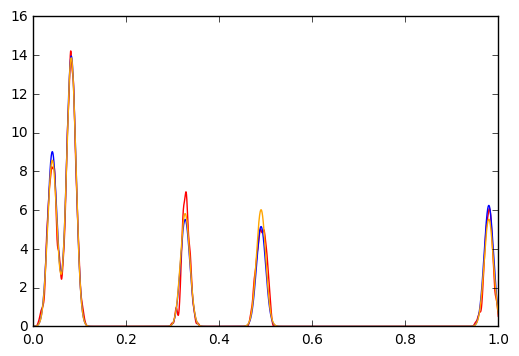

In [21]:
plt.plot(np.linspace(0,1,n_pdf),y, color="red")
plt.plot(np.linspace(0,1,n_pdf),f_star, color="blue")
#plt.plot(np.linspace(0,1,n_pdf),f_estim_dantzig, color="green")
plt.plot(np.linspace(0,1,n_pdf),f_estim, color="orange")
plt.show()

In [18]:
from pythonABC.hselect import hsj

In [19]:
hsj(X)

0.0073533511853496767